<a id='ndvi_anomaly_top'></a>
# NDVI Anomaly

<hr>

# Notebook Summary

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#ndvi_anomaly_import)
* [Choose Platform and Product](#ndvi_anomaly_plat_prod)
* [Define the Extents of the Analysis](#ndvi_anomaly_define_extents)
* [Load Data from the Data Cube](#ndvi_anomaly_load_data)
* [Create Composites](#ndvi_anomaly_composites)
* [NDVI Anomaly](#ndvi_anomaly_anomaly)
* [NDVI Anomaly Threshold Product](#ndvi_anomaly_threshold)

## <span id="ndvi_anomaly_import">Import Dependencies and Connect to the Data Cube [&#9652;](#ndvi_std_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import copy

import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
from matplotlib.ticker import FuncFormatter

from utils.data_cube_utilities.dc_load import is_dataset_empty, get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import \
    landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map

from datacube.utils.aws import configure_s3_access
configure_s3_access(requester_pays=True)

import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="ndvi_anomaly_plat_prod">Choose Platform and Product [&#9652;](#ndvi_anomaly_top)</span>

In [2]:
# Get available products
products_info = dc.list_products()

In [3]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
4,LANDSAT_7,ls7_usgs_sr_scene


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


In [37]:
# Select platform and product.
product = 'ls7_usgs_sr_scene'
platform = 'LANDSAT_7'
collection = 'c1'
level = 'l2'

In [38]:
full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.524861111211308, 15.436527777901272)
Longitude Extents: (-19.46597222237795, 43.12541666701167)
Time Extents: ['2000-01-02', '2019-12-29']


## <span id="ndvi_anomaly_define_extents">Define the Extents of the Analysis [&#9652;](#ndvi_anomaly_top)</span>

In [57]:
# Select an analysis region and visualize the region

# Dodoma, Tanzania
latitude = (-6.22, -6.12) 
longitude = (35.70, 35.81) 

In [58]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = latitude, longitude = longitude)

In [60]:
# To compare the NDVI values from two time periods (baseline and analysis), 
# it is best to create "Maximum NDVI" cloud-free mosaics and then compare the changes

# Select the baseline time period (start and end)
baseline_time_period = ("2000-01-01", "2000-12-31")

# Select the analysis time period (start and end)
analysis_time_period = ("2016-01-01", "2016-12-31") 

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
# It is most common to use the maximum NDVI mosaic for this analysis

baseline_mosaic_function = "max_ndvi" 
analysis_mosaic_function = "max_ndvi" 

# Select a baseline NDVI threshold range
# The analysis will only consider pixels in this range for change detection
# Example: use 0.6 to 0.9 for dense vegetation, grasslands are 0.2 to 0.6
ndvi_baseline_threshold_range = (0.6, 0.9)  

## <span id="ndvi_anomaly_load_data">Load Data from the Data Cube [&#9652;](#ndvi_anomaly_top)</span>

>#### Load Data ( Baseline, Analysis) 

In [61]:
commmon_load_params = \
    dict(latitude = latitude, longitude = longitude, 
         product = product, platform = platform,
         measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"],
         dask_chunks={'time':1, 'latitude':1000, 'longitude':1000})

In [62]:
baseline_ds = dc.load(
    time = baseline_time_period,
    **commmon_load_params
)

In [63]:
analysis_ds = dc.load(
    time = analysis_time_period,
    **commmon_load_params
)

> #### Check if loads are valid

In [64]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [65]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [67]:
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_full

clean_mask_common_params = dict(product=product, platform=platform, 
                                collection=collection, level=level)
baseline_clean_mask = landsat_clean_mask_full(dc, baseline_ds, **clean_mask_common_params)
analysis_clean_mask = landsat_clean_mask_full(dc, analysis_ds, **clean_mask_common_params)

In [68]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

## <span id="ndvi_anomaly_composites">Create Composites [&#9652;](#ndvi_anomaly_top)</span>

In [69]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [70]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [71]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask)

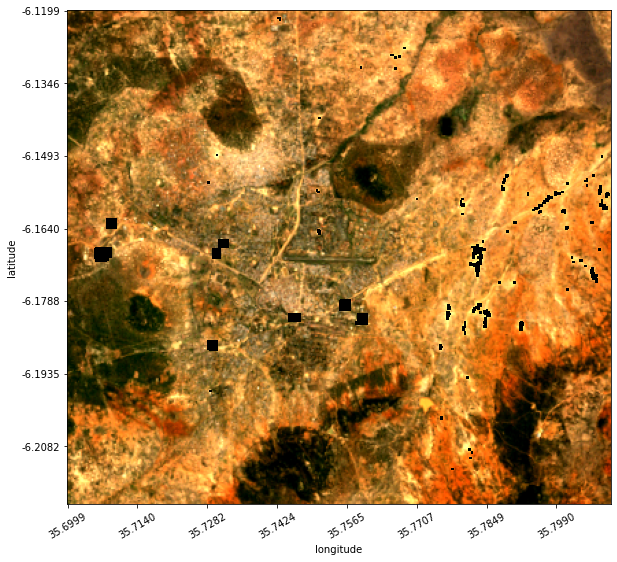

In [72]:
from utils.data_cube_utilities.plotter_utils import figure_ratio
std_figsize = figure_ratio(baseline_composite, fixed_width=10)
fig = plt.figure(figsize = std_figsize)
rgb(baseline_composite, fig=fig)
plt.show()

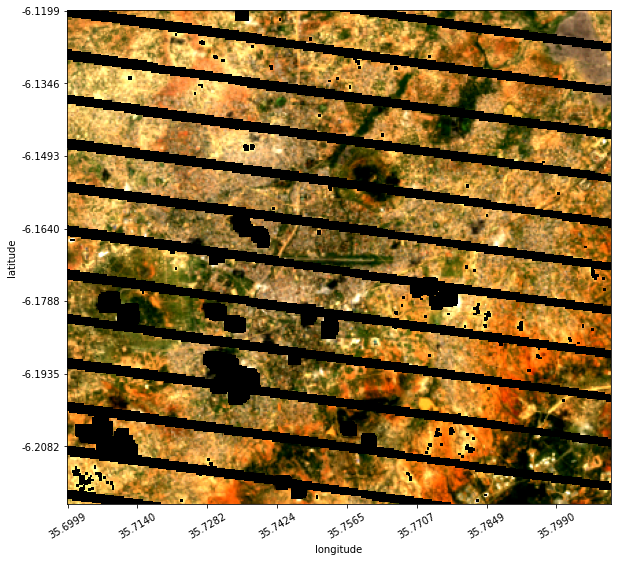

In [73]:
fig = plt.figure(figsize = std_figsize)
rgb(analysis_composite, fig=fig)
plt.show()

>#### Baseline Mosaic using the NDVI Threshold Range
The image below will mask clouds and only include pixels that fall within the threshold range

In [74]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [75]:
_min, _max = ndvi_baseline_threshold_range  
baseline_ndvi_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    

In [76]:
def aspect_ratio_helper(ds, fixed_width = 15):
    y,x = ds.values.shape
    width = fixed_width
    height = y * (fixed_width / x)
    return (width, height)

In [77]:
# Copy the colormaps to be able to modify them.
RdYlGn = copy.copy(RdYlGn)
Greens = copy.copy(Greens)
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

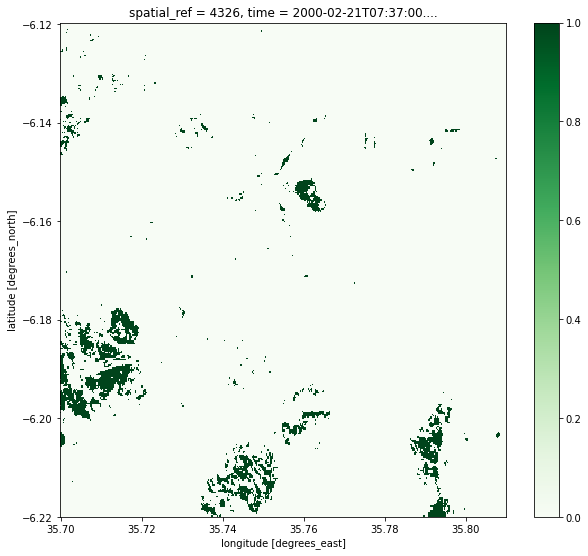

In [78]:
# This is the baseline NDVI threshold plot that shows GREEN pixels in the threshold range
# plt.figure(figsize = aspect_ratio_helper(baseline_ndvi_filter_mask)) 
fig = plt.figure(figsize = std_figsize)
baseline_ndvi_filter_mask.plot(cmap = "Greens")
plt.show()

In [79]:
baseline_composite = baseline_composite.where(baseline_ndvi_filter_mask)

## <span id="ndvi_anomaly_anomaly">NDVI Anomaly [&#9652;](#ndvi_anomaly_top)</span>

In [80]:
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

In [81]:
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

>#### NDVI Anomaly Plot


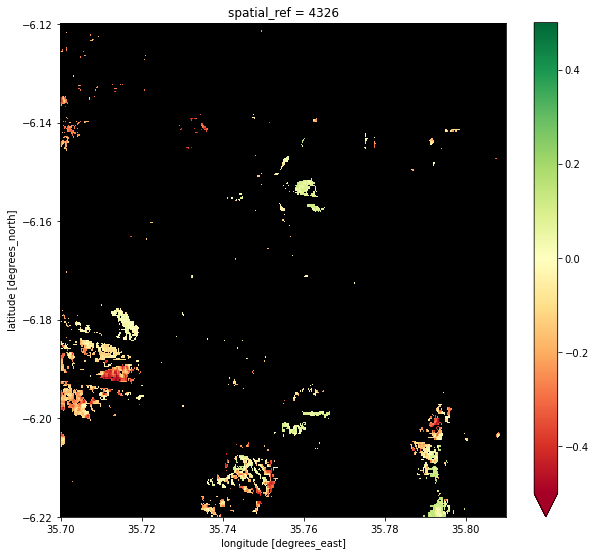

In [82]:
fig = plt.figure(figsize = std_figsize)
ndvi_anomaly.plot(vmin=-0.5, vmax=0.5, cmap = RdYlGn)
plt.show()

>#### Discretized/Binned plot

/env/lib/python3.6/site-packages/xarray/plot/plot.py:970: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  primitive = ax.pcolormesh(x, y, z, **kwargs)


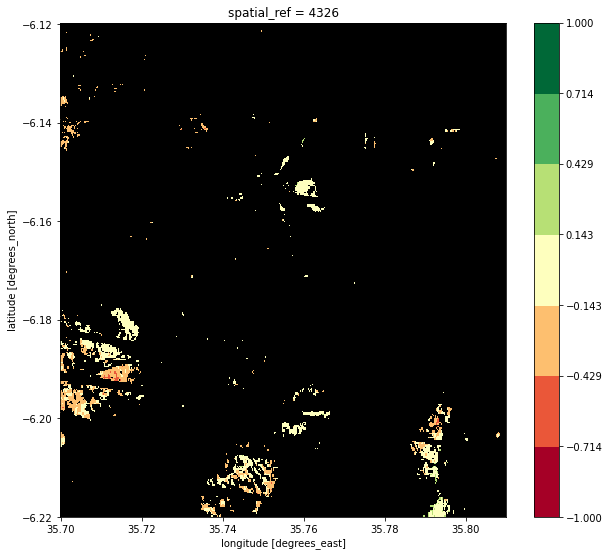

In [83]:
fig = plt.figure(figsize = std_figsize)
ndvi_anomaly.plot(levels = 8, vmin=-1, vmax=1, cmap = RdYlGn)
plt.show()

In [84]:
cmap = create_discrete_color_map(data_range=(-1,1), 
                                 th=[0.0], colors=[(240,93,94), (126,243,125)])
cmap.set_bad("black", 1.)

>#### NDVI Anomaly

This product shows the following ...<br>
BLACK = Cloud or Pixels NOT in the baseline threshold range<br>
GREEN = Pixels with an increase in NDVI<br>
RED = Pixels with a decrease in NDVI<br>

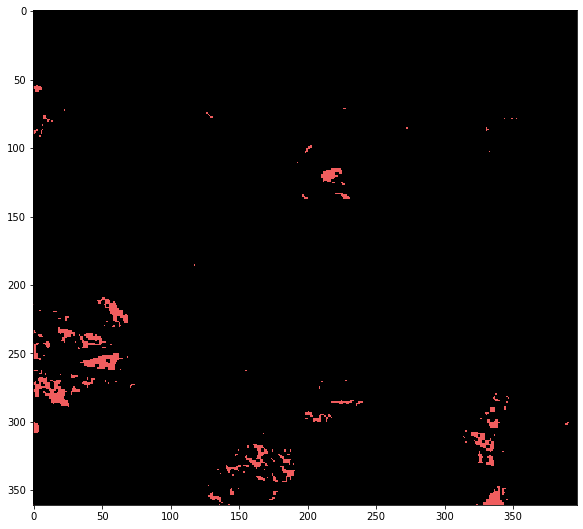

In [85]:
fig = plt.figure(figsize = std_figsize)
plt.imshow(ndvi_anomaly.values, cmap=cmap, vmin=-1, vmax=1)
plt.show()

## <span id="ndvi_anomaly_threshold">NDVI Anomaly Threshold Product [&#9652;](#ndvi_anomaly_top)</span>

In [86]:
# Select NDVI Anomaly Threshold Range
# We are looking for pixels that have lost significant vegetation
# NDVI losses are typically 0.1 or more for deforestation

minimum_change = -0.6
maximum_change = -0.2

>#### NDVI Change Distribution
Threshold range, highlighted in red

In [87]:
def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)

In [88]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values)) 

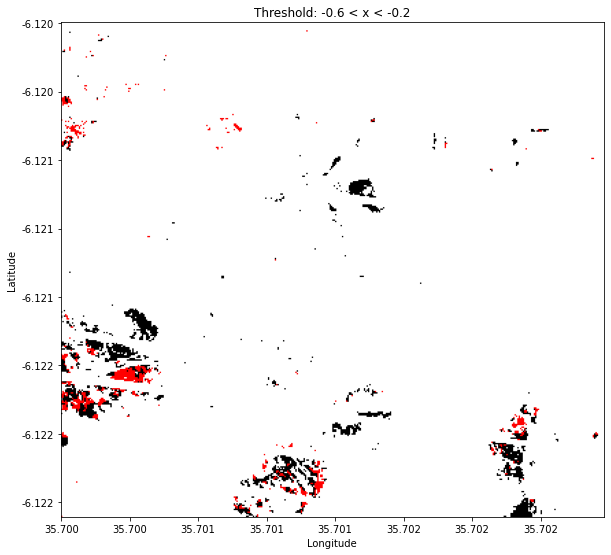

In [89]:
threshold_plot(ndvi_anomaly, minimum_change, maximum_change, 
               mask = no_data_mask, width = 10)
plt.show()

In [90]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [91]:
threshold_count(ndvi_anomaly,minimum_change,maximum_change)

{'total': 143317, 'total_non_cloudy': 3977, 'inside': 1074, 'outside': 2903}

In [92]:
threshold_percentage(ndvi_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 0.7493877209263381,
 'percent_outside_threshold': 2.0255796590774295,
 'percent_clouds': 97.22503261999623}